In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pathlib
import os

MODEL = pathlib.Path('wall_recognizer.keras')
LABELLED = pathlib.Path('Dataset', 'Wall Recognizer', 'Labelled')

In [39]:
BUFFER = 128

file_paths = tf.data.Dataset.list_files(str(LABELLED/'*.png'), shuffle=False).shuffle(BUFFER, reshuffle_each_iteration=False)

In [48]:
def parse_images(file_path):
    # extract label
    label = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(label, '_')[:-1]
    label = tf.strings.to_number(label, tf.int32)

    # load image
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255
    return image, label

dataset = file_paths.map(parse_images)

In [49]:
train_size = 1600

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [50]:
image = iter(train_dataset).__next__()
print(image[0].shape)

(28, 28, 1)


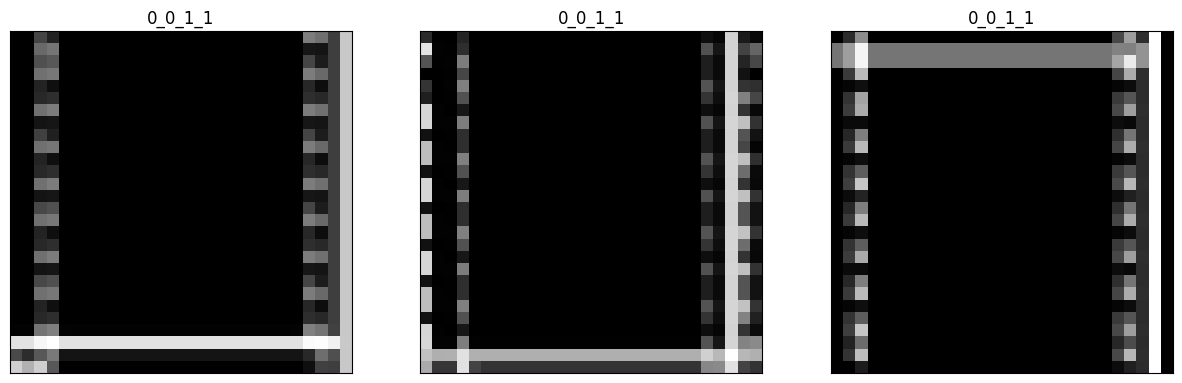

In [51]:
plt.figure(figsize=(15, 5))
for i, (image, label) in zip(range(3), iter(train_dataset)):
    label = label.numpy().astype(np.uint8).tolist()

    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('_'.join([str(x) for x in label]))
plt.show()

In [52]:
train_dataset = train_dataset.batch(128)
test_dataset = test_dataset.batch(128)

In [53]:
def get_model():
    model = keras.Sequential()

    # input layer
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))

    # first convolution layer
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # second convolution layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # transition to fully connected layers
    model.add(keras.layers.Flatten())

    # first dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # second dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(4, kernel_initializer='he_uniform', activation='sigmoid'))
    return model

In [54]:
# create a model
model = get_model()
print(model.summary())
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics='accuracy'
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 re_lu_12 (ReLU)             (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 re_lu_13 (ReLU)             (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                 

In [55]:
for file in os.listdir('Checkpoints'):
    os.remove(f'Checkpoints/{file}')

In [56]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [57]:
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/100
13/13 [==============================] - 4s 160ms/step - loss: 0.8379 - accuracy: 0.2025 - val_loss: 0.7901 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 2s 160ms/step - loss: 0.7097 - accuracy: 0.2119 - val_loss: 0.7229 - val_accuracy: 0.0141
Epoch 3/100
13/13 [==============================] - 2s 151ms/step - loss: 0.6644 - accuracy: 0.2619 - val_loss: 0.6786 - val_accuracy: 0.0634
Epoch 4/100
13/13 [==============================] - 2s 163ms/step - loss: 0.6498 - accuracy: 0.2988 - val_loss: 0.6539 - val_accuracy: 0.1174
Epoch 5/100
13/13 [==============================] - 2s 179ms/step - loss: 0.6379 - accuracy: 0.2956 - val_loss: 0.6412 - val_accuracy: 0.1643
Epoch 6/100
13/13 [==============================] - 2s 161ms/step - loss: 0.6204 - accuracy: 0.3475 - val_loss: 0.6228 - val_accuracy: 0.2676
Epoch 7/100
13/13 [==============================] - 2s 184ms/step - loss: 0.6140 - accuracy: 0.3606 - val_loss: 0.6140 - val_accuracy: 0.

In [58]:
model.evaluate(test_dataset)

4/4 [==============================] - 1s 24ms/step - loss: 0.2095 - accuracy: 0.3873


[0.20947317779064178, 0.38732394576072693]

In [59]:
predictions = (model.predict(test_dataset) < 0.5)[0]
tuple(predictions)

4/4 [==============================] - 1s 20ms/step


(False, False, True, False)

In [60]:
# save the model
model.save('wall_recognizer.keras')